In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import tensorflow as tf

In [2]:
import os
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [8]:
dataset_path = "/content/drive/MyDrive/Post Mortem Estimation/Warsaw-BioBase-Postmortem-Iris-v3/RGB_Cropped_ISO-Resolution_renamed"
image_paths = []
labels = []

In [9]:
IMAGE_SIZE = (224, 224)

In [10]:
image_files = [f for f in os.listdir(dataset_path) if f.endswith('.bmp')]

for image_file in image_files:
    parts = image_file.split('_')
    try:
        pmi_hours = float(parts[2])
    except ValueError:
        continue

    image_path = os.path.join(dataset_path, image_file)
    image_paths.append(image_path)
    labels.append(pmi_hours)

print("Total images:", len(image_paths))
print("Total labels:", len(labels))

Total images: 2612
Total labels: 2612


Loading images: 100%|██████████| 523/523 [00:03<00:00, 140.53it/s]


X_train_images shape: (2089, 224, 224, 3)
X_test_images shape: (523, 224, 224, 3)
y_train shape: (2089,)
y_test shape: (523,)


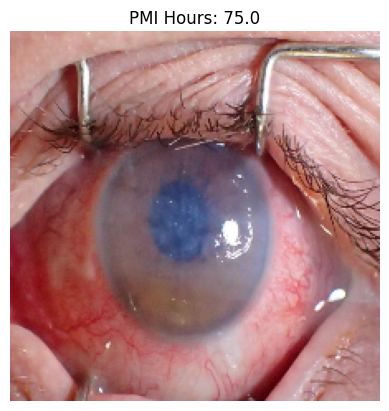

In [11]:
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

def load_and_preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)

    # Centered cropping
    h, w = image.shape[:2]
    min_dim = min(h, w)
    start_x = (w - min_dim) // 2
    start_y = (h - min_dim) // 2
    image = image[start_y:start_y + min_dim, start_x:start_x + min_dim]

    # Resize to 224x224 pixels
    image = cv2.resize(image, IMAGE_SIZE)

    # Normalize to [0, 1] range
    image = image / 255.0

    return image

# Load and preprocess in parallel
def load_images_parallel(image_paths):
    with ThreadPoolExecutor(max_workers=8) as executor:  # Adjust the number of workers as needed
        images = list(tqdm(executor.map(load_and_preprocess_image, image_paths), total=len(image_paths), desc="Loading images"))
    return np.array(images)

# convert X_train to a NumPy array if it's a list
X_train = np.array(X_train)
X_test = np.array(X_test)
X_train_images = load_images_parallel(X_train)
X_test_images = load_images_parallel(X_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

print("X_train_images shape:", X_train_images.shape)
print("X_test_images shape:", X_test_images.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# Show an example image
def show_image(image_path, label):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, IMAGE_SIZE)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(f"PMI Hours: {label}")
    plt.axis('off')
    plt.show()

show_image(X_train[0], y_train[0])

In [15]:
print(type(X_train))

<class 'list'>


In [12]:
for filename, label in zip(image_files[:10], labels[:10]):
    print(f"Filename: {filename}, Label: {label}")

def load_image(filepath):
    image = cv2.imread(filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, IMAGE_SIZE)
    return image

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

# Check the first few filenames and labels
for filename, label in zip(image_files[:10], labels[:10]):
    print(f"Filename: {filename}, Label: {label}")

# # Example to show an image with its label
# def show_image(image_path, label):
#     image = load_image(image_path)
#     plt.imshow(image)
#     plt.title(f"PMI Class: {label}")
#     plt.axis('off')
#     plt.show()

# # Show an example image
# show_image(X_train[0], y_train[0])

Filename: 0114_R_150_1.bmp, Label: 150.0
Filename: 0114_R_150_2.bmp, Label: 150.0
Filename: 0114_R_150_3.bmp, Label: 150.0
Filename: 0114_R_150_4.bmp, Label: 150.0
Filename: 0114_R_150_5.bmp, Label: 150.0
Filename: 0115_L_7_1.bmp, Label: 7.0
Filename: 0115_L_7_2.bmp, Label: 7.0
Filename: 0115_L_7_3.bmp, Label: 7.0
Filename: 0115_L_7_4.bmp, Label: 7.0
Filename: 0115_L_54_1.bmp, Label: 54.0
Filename: 0114_R_150_1.bmp, Label: 150.0
Filename: 0114_R_150_2.bmp, Label: 150.0
Filename: 0114_R_150_3.bmp, Label: 150.0
Filename: 0114_R_150_4.bmp, Label: 150.0
Filename: 0114_R_150_5.bmp, Label: 150.0
Filename: 0115_L_7_1.bmp, Label: 7.0
Filename: 0115_L_7_2.bmp, Label: 7.0
Filename: 0115_L_7_3.bmp, Label: 7.0
Filename: 0115_L_7_4.bmp, Label: 7.0
Filename: 0115_L_54_1.bmp, Label: 54.0


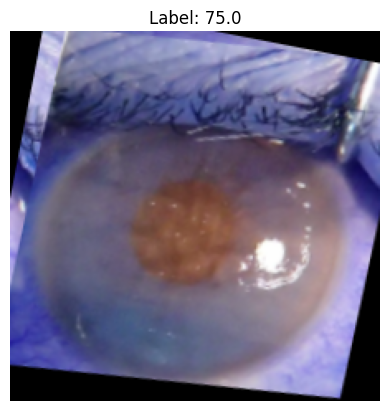

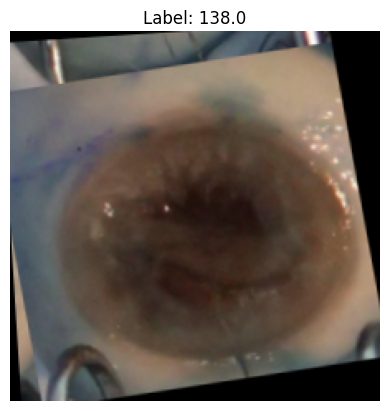

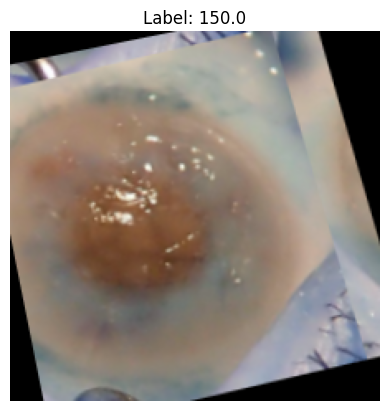

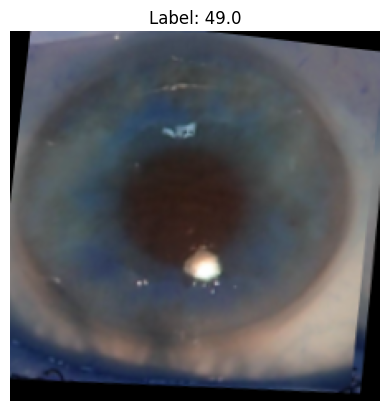

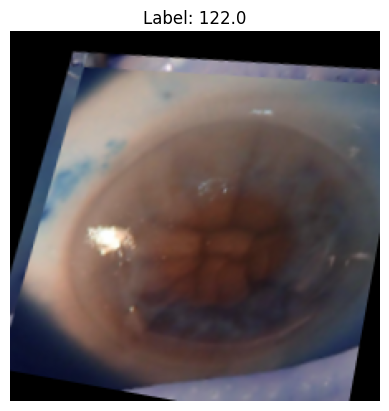

In [13]:
def augment_image(image):
    # Zoom
    zoom_factor = 1.3
    height, width = image.shape[:2]
    zoomed_image = cv2.resize(image, None, fx=zoom_factor, fy=zoom_factor)
    crop_x = (zoomed_image.shape[1] - width) // 2
    crop_y = (zoomed_image.shape[0] - height) // 2
    zoomed_image = zoomed_image[crop_y:crop_y+height, crop_x:crop_x+width]

    # Width and Height Shifts
    max_shift = 0.3
    dx = int(max_shift * width * (np.random.rand() - 0.5))
    dy = int(max_shift * height * (np.random.rand() - 0.5))
    shifted_image = np.roll(zoomed_image, (dy, dx), axis=(0, 1))

    # Shear
    shear_factor = 0.3
    shear_matrix = np.array([[1, shear_factor * (np.random.rand() - 0.5), 0],
                             [shear_factor * (np.random.rand() - 0.5), 1, 0]], dtype=np.float32)
    sheared_image = cv2.warpAffine(shifted_image, shear_matrix, (width, height))

    # Rotation
    angle = 30 * (np.random.rand() - 0.5)
    rotation_matrix = cv2.getRotationMatrix2D((width // 2, height // 2), angle, 1)
    rotated_image = cv2.warpAffine(sheared_image, rotation_matrix, (width, height))

    # Flips
    if np.random.rand() > 0.5:
        flipped_image = cv2.flip(rotated_image, 1)  # Horizontal flip
    else:
        flipped_image = rotated_image

    if np.random.rand() > 0.5:
        flipped_image = cv2.flip(flipped_image, 0)  # Vertical flip

    return flipped_image

# Apply
augmented_images = [augment_image(image) for image in X_train_images]

# Visualize
for i in range(5):
    plt.imshow(augmented_images[i].squeeze(), cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
    plt.show()

In [14]:
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.regularizers import l2

base_model = ResNet152(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# Custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.06)(x)
predictions = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

print(X_train_images.shape)
print(X_train.shape)

history = model.fit(X_train_images.reshape(-1, IMAGE_SIZE[0], IMAGE_SIZE[1], 3), y_train,
                    epochs=10, batch_size=128, validation_split=0.2, callbacks=[callback])

234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step
(2089, 224, 224, 3)


AttributeError: 'list' object has no attribute 'shape'

In [ ]:
# evaluate the model
loss, accuracy = model.evaluate(X_test.reshape(-1, IMAGE_SIZE[0], IMAGE_SIZE[1], 3), y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

# unfreeze some layers of the base model and fine-tune
for layer in base_model.layers[:249]:
    layer.trainable = True
for layer in base_model.layers[249:]:
    layer.trainable = False

# recompile the model after unfreezing
model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# fine-tune the model
history = model.fit(X_train.reshape(-1, IMAGE_SIZE[0], IMAGE_SIZE[1], 3), y_train,
                    epochs=10, batch_size=32, validation_split=0.2, callbacks=[callback])

# evaluate the fine-tuned model
loss, accuracy = model.evaluate(X_test.reshape(-1, IMAGE_SIZE[0], IMAGE_SIZE[1], 3), y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')


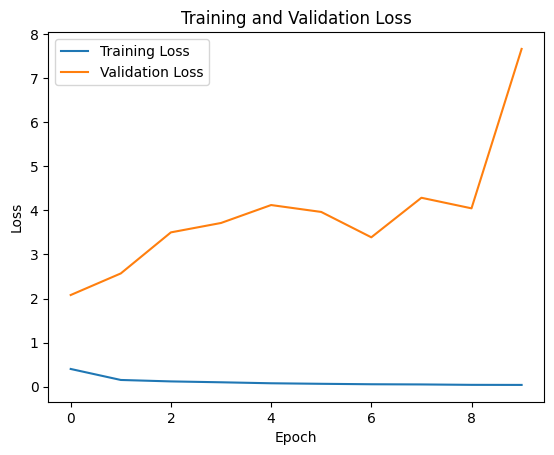

In [ ]:
# from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
model.save('detection-model-inception-11juni.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
